# Telco Churn Analysis Notebook
Created by:
- Aqna Najmunnisa Maulidia 
- Setyo Tirta Abimanyu
- Azka Fachrizal Amni

This notebook was created as a part of Data Science Indonesia Competition (@datascienceindo).

# Problem Statement

A telecommunication company wants to analyze its customer's behavior. Given the following dataset, build a solution that aims to provide meaningful insights to the telecommunication company. The solution can be in the form of an **AI model, dashboard, or analysis report**

# Importing Library

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import fbeta_score



sns.set_style('whitegrid')

# Getting the Data

In [6]:
df = pd.read_excel('Telco_customer_churn_adapted_v2.xlsx', sheet_name = 'Sheet1')
df.head()

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,106.816666,-6.2,4210.7
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,106.816666,-6.2,3511.3
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,106.816666,-6.2,6983.6
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,106.816666,-6.2,6503.9
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,106.816666,-6.2,6942.0


# Data Preparation

## Dropping ID column
We will be dropping the ID column since we don't need it for modelling purpose.

In [7]:
cust_id = df['Customer ID']
df = df.drop('Customer ID', axis = 1)

df.head()

,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,106.816666,-6.2,4210.7
1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,106.816666,-6.2,3511.3
2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,106.816666,-6.2,6983.6
3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,106.816666,-6.2,6503.9
4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,106.816666,-6.2,6942.0


In [8]:
print(f"Number of rows : {df.shape[0]}")
print(f"Number of columns : {df.shape[1]}")

Number of rows : 7043
Number of columns : 15


In [9]:
print(f"Number of rows before removing duplicate : {df.shape[0]}")
df.drop_duplicates(inplace = True, keep = 'first')
print(f"Number of rows after dropping duplicates : {df.shape[0]}")

Number of rows before removing duplicate : 7043
Number of rows after dropping duplicates : 7043


No duplicate row found in the data.

In [10]:
cat_col = df.select_dtypes('object').columns

for col in cat_col:
    print(f"{col} : ")
    print(df[col].unique())
    print()

Location : 
['Jakarta' 'Bandung']

Device Class : 
['Mid End' 'High End' 'Low End']

Games Product : 
['Yes' 'No' 'No internet service']

Music Product : 
['Yes' 'No' 'No internet service']

Education Product : 
['No' 'Yes' 'No internet service']

Call Center : 
['No' 'Yes']

Video Product : 
['No' 'Yes' 'No internet service']

Use MyApp : 
['No' 'Yes' 'No internet service']

Payment Method : 
['Digital Wallet' 'Pulsa' 'Debit' 'Credit']

Churn Label : 
['Yes' 'No']



In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Tenure Months                 7043 non-null   int64  
 1   Location                      7043 non-null   object 
 2   Device Class                  7043 non-null   object 
 3   Games Product                 7043 non-null   object 
 4   Music Product                 7043 non-null   object 
 5   Education Product             7043 non-null   object 
 6   Call Center                   7043 non-null   object 
 7   Video Product                 7043 non-null   object 
 8   Use MyApp                     7043 non-null   object 
 9   Payment Method                7043 non-null   object 
 10  Monthly Purchase (Thou. IDR)  7043 non-null   float64
 11  Churn Label                   7043 non-null   object 
 12  Longitude                     7043 non-null   float64
 13  Lat

In [12]:
df.drop(['Longitude', 'Latitude'], axis = 1).describe()

,Tenure Months,Monthly Purchase (Thou. IDR),CLTV (Predicted Thou. IDR)
count,7043.000000,7043.000000,7043.000000
mean,32.371149,84.190200,5720.384481
std,24.559481,39.117061,1537.974298
min,0.000000,23.725000,2603.900000
25%,9.000000,46.150000,4509.700000
50%,29.000000,91.455000,5885.100000
75%,55.000000,116.805000,6994.650000
max,72.000000,154.375000,8450.000000


# EDA

In [13]:
df.head()

,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,106.816666,-6.2,4210.7
1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,106.816666,-6.2,3511.3
2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,106.816666,-6.2,6983.6
3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,106.816666,-6.2,6503.9
4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,106.816666,-6.2,6942.0


In [14]:
df.groupby('Churn Label')['Device Class'].value_counts()

Churn Label  Device Class
No           Mid End         1962
             High End        1799
             Low End         1413
Yes          High End        1297
             Mid End          459
             Low End          113
Name: Device Class, dtype: int64

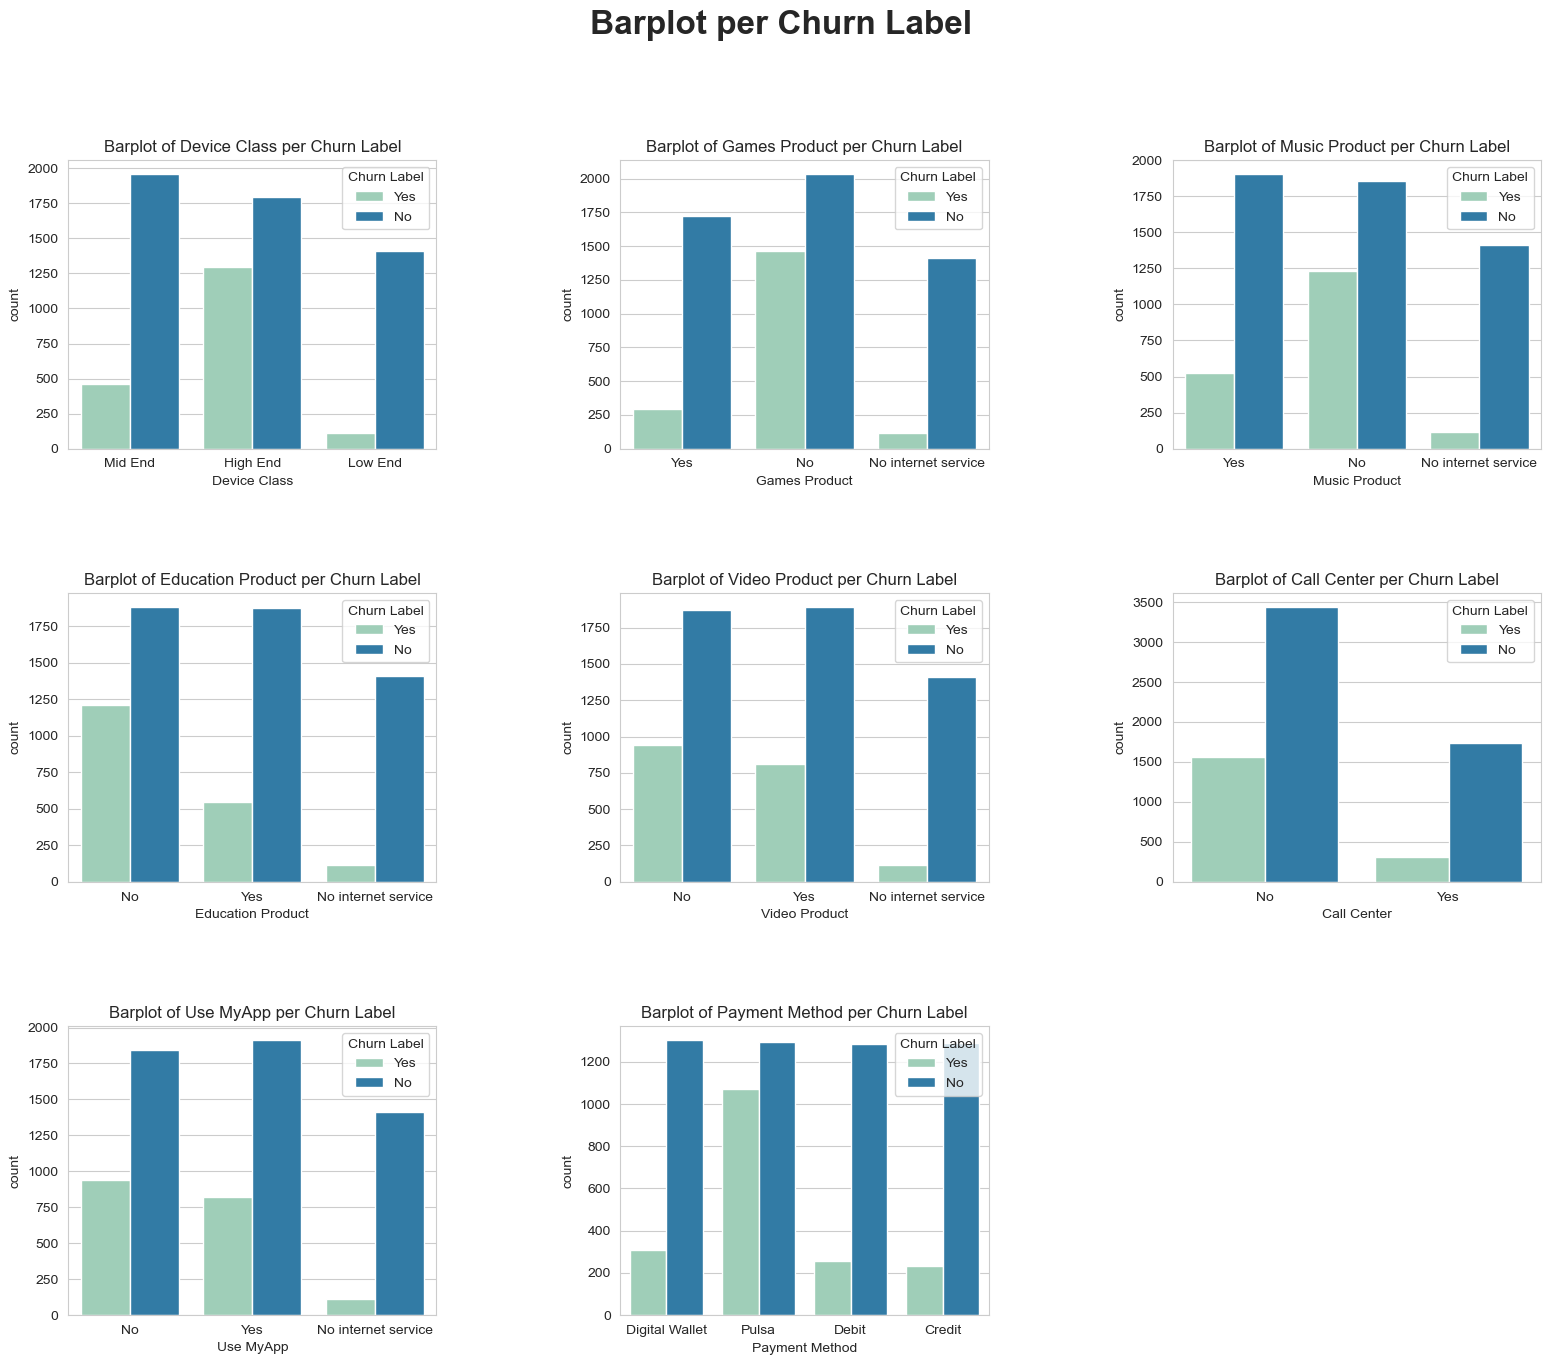

In [15]:
plot_col = ['Device Class', 'Games Product', 'Music Product',
            'Education Product', 'Video Product','Call Center',
            'Use MyApp', 'Payment Method']

plt.figure(figsize=(19,15))
plt.suptitle(f"Barplot per Churn Label", fontweight = 'bold', fontsize = 24)
plt.subplots_adjust(hspace=0.5, wspace = 0.5)
plt.subplots_adjust()


for n, col in enumerate(plot_col):
    ax = plt.subplot(3,3, n + 1)
    
    sns.countplot(df, x = col, axes = ax,
                 hue = 'Churn Label',
                 palette = 'YlGnBu')
    plt.title(f"Barplot of {col} per Churn Label")

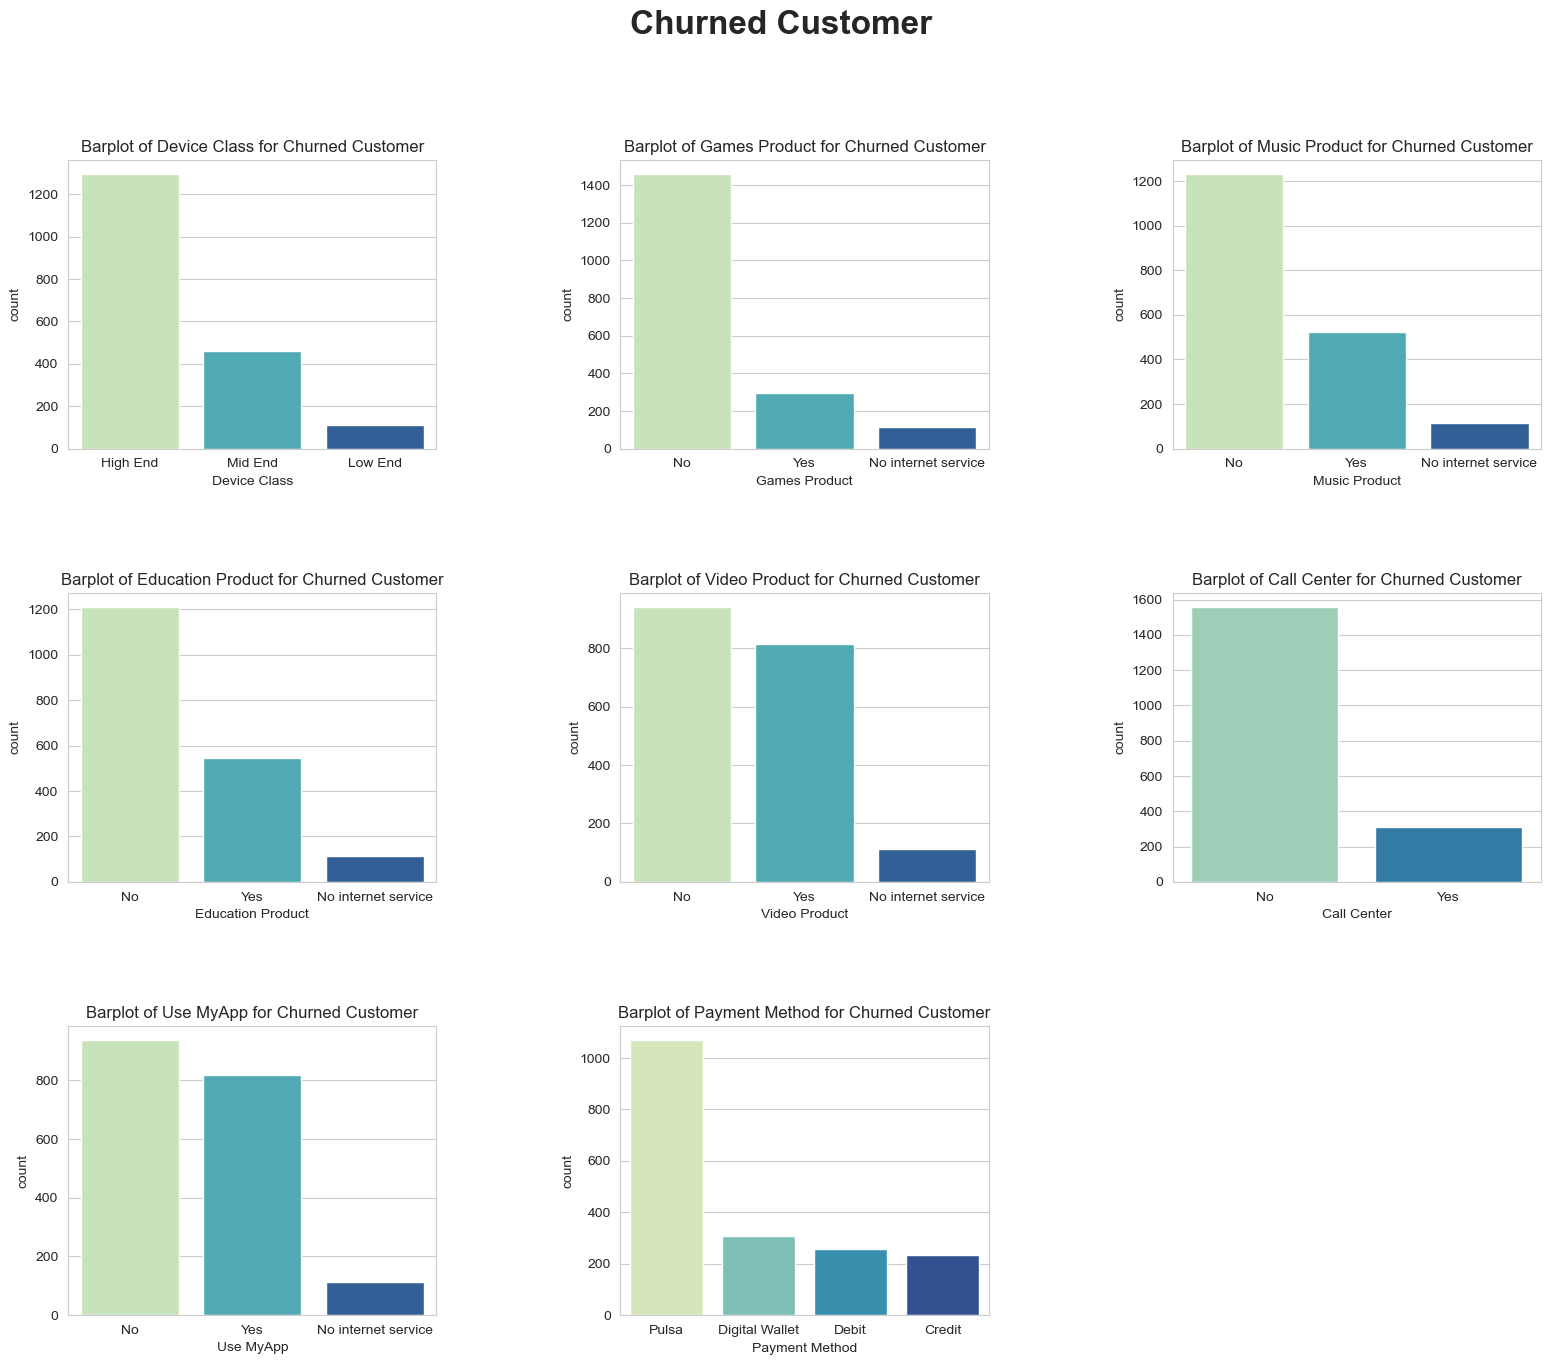

In [16]:
churn_yes = df.loc[df['Churn Label'] == 'Yes']

plot_col = ['Device Class', 'Games Product', 'Music Product',
            'Education Product', 'Video Product','Call Center',
            'Use MyApp', 'Payment Method']

plt.figure(figsize=(19,15))
plt.suptitle('Churned Customer', fontsize = 24, fontweight = 'bold')
plt.subplots_adjust(hspace=0.5, wspace = 0.5)
plt.subplots_adjust()


for n, col in enumerate(plot_col):
    ax = plt.subplot(3,3, n + 1)
    
    sns.countplot(churn_yes, x = col, axes = ax,
                 palette = 'YlGnBu', order = churn_yes[col].value_counts().index)
    plt.title(f"Barplot of {col} for Churned Customer")

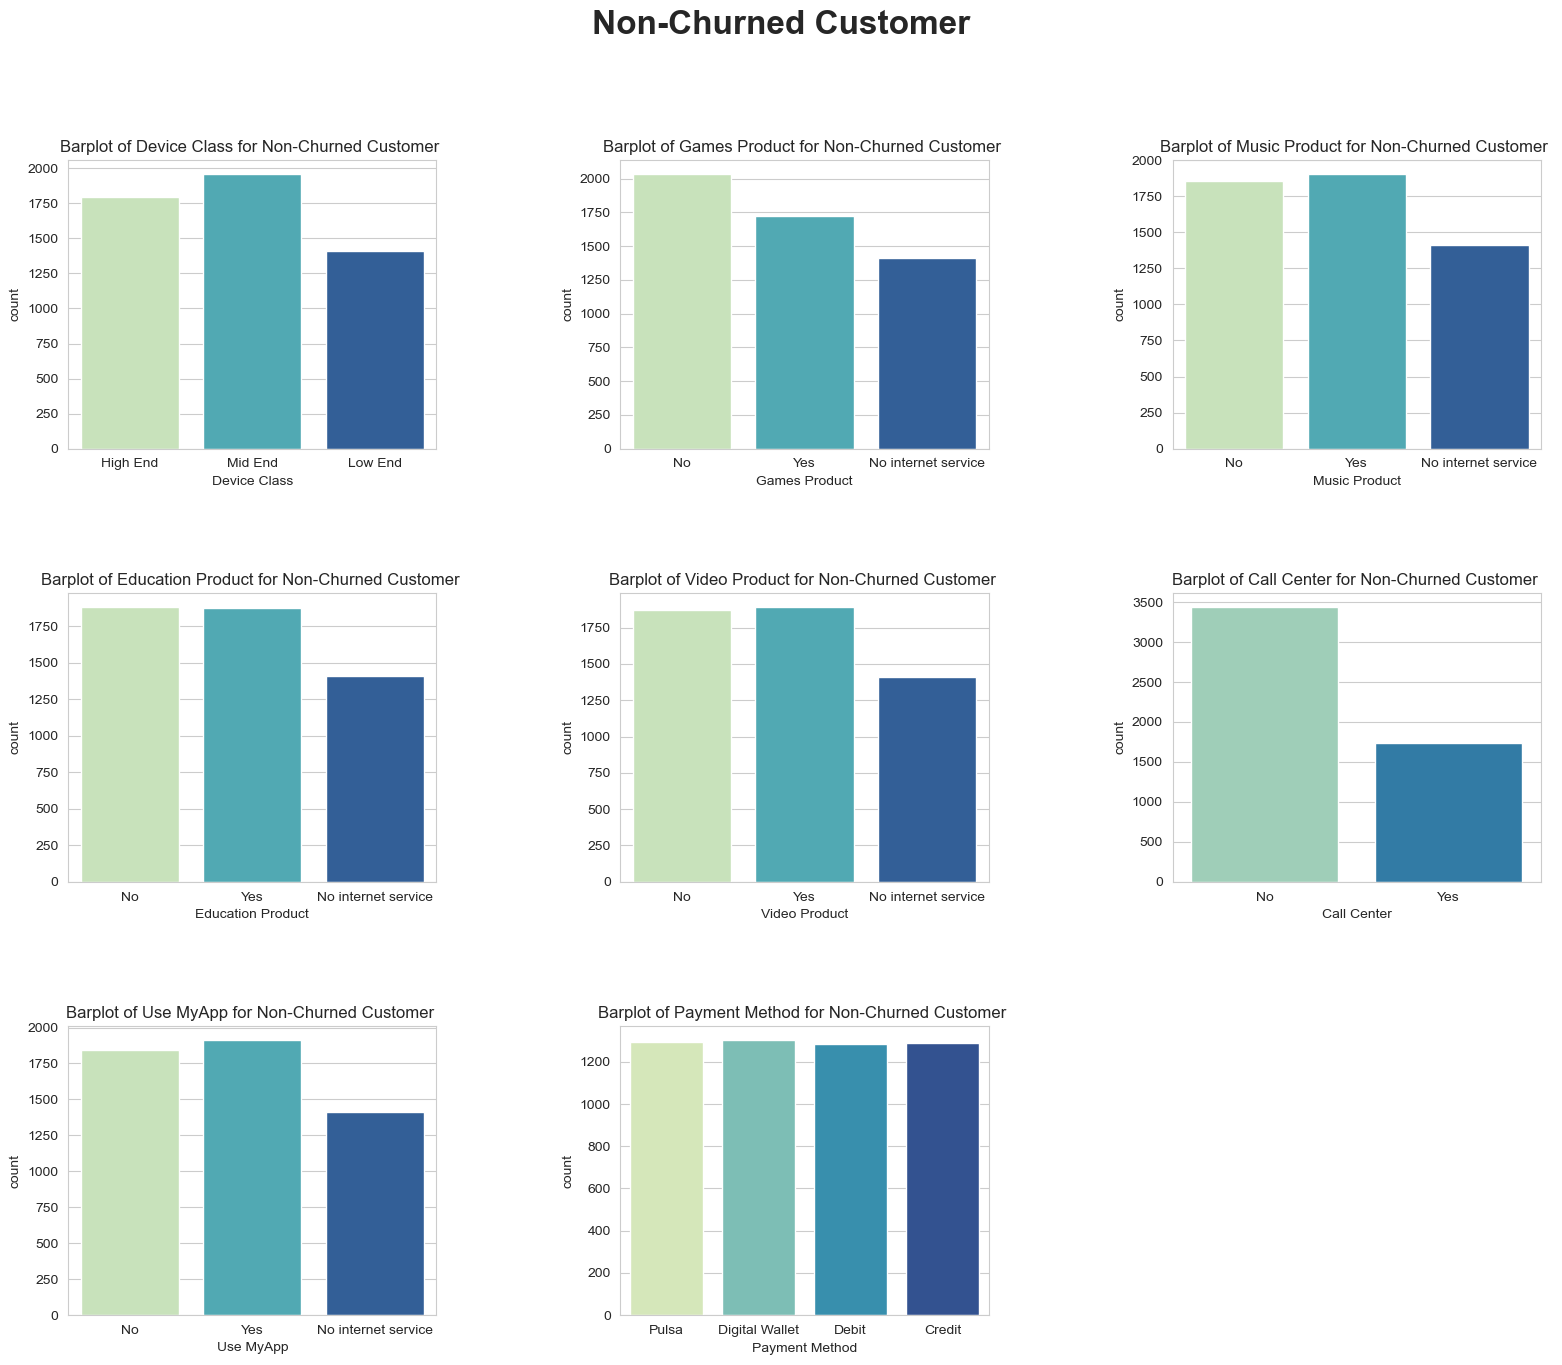

In [17]:
churn_no = df.loc[df['Churn Label'] == 'No']

plot_col = ['Device Class', 'Games Product', 'Music Product',
            'Education Product', 'Video Product','Call Center',
            'Use MyApp', 'Payment Method']

plt.figure(figsize=(19,15))
plt.suptitle('Non-Churned Customer', fontsize = 24, fontweight = 'bold')
plt.subplots_adjust(hspace=0.5, wspace = 0.5)
plt.subplots_adjust()


for n, col in enumerate(plot_col):
    ax = plt.subplot(3,3, n + 1)
    
    sns.countplot(churn_no, x = col, axes = ax,
                 palette = 'YlGnBu', order = churn_yes[col].value_counts().index)
    plt.title(f"Barplot of {col} for Non-Churned Customer ")

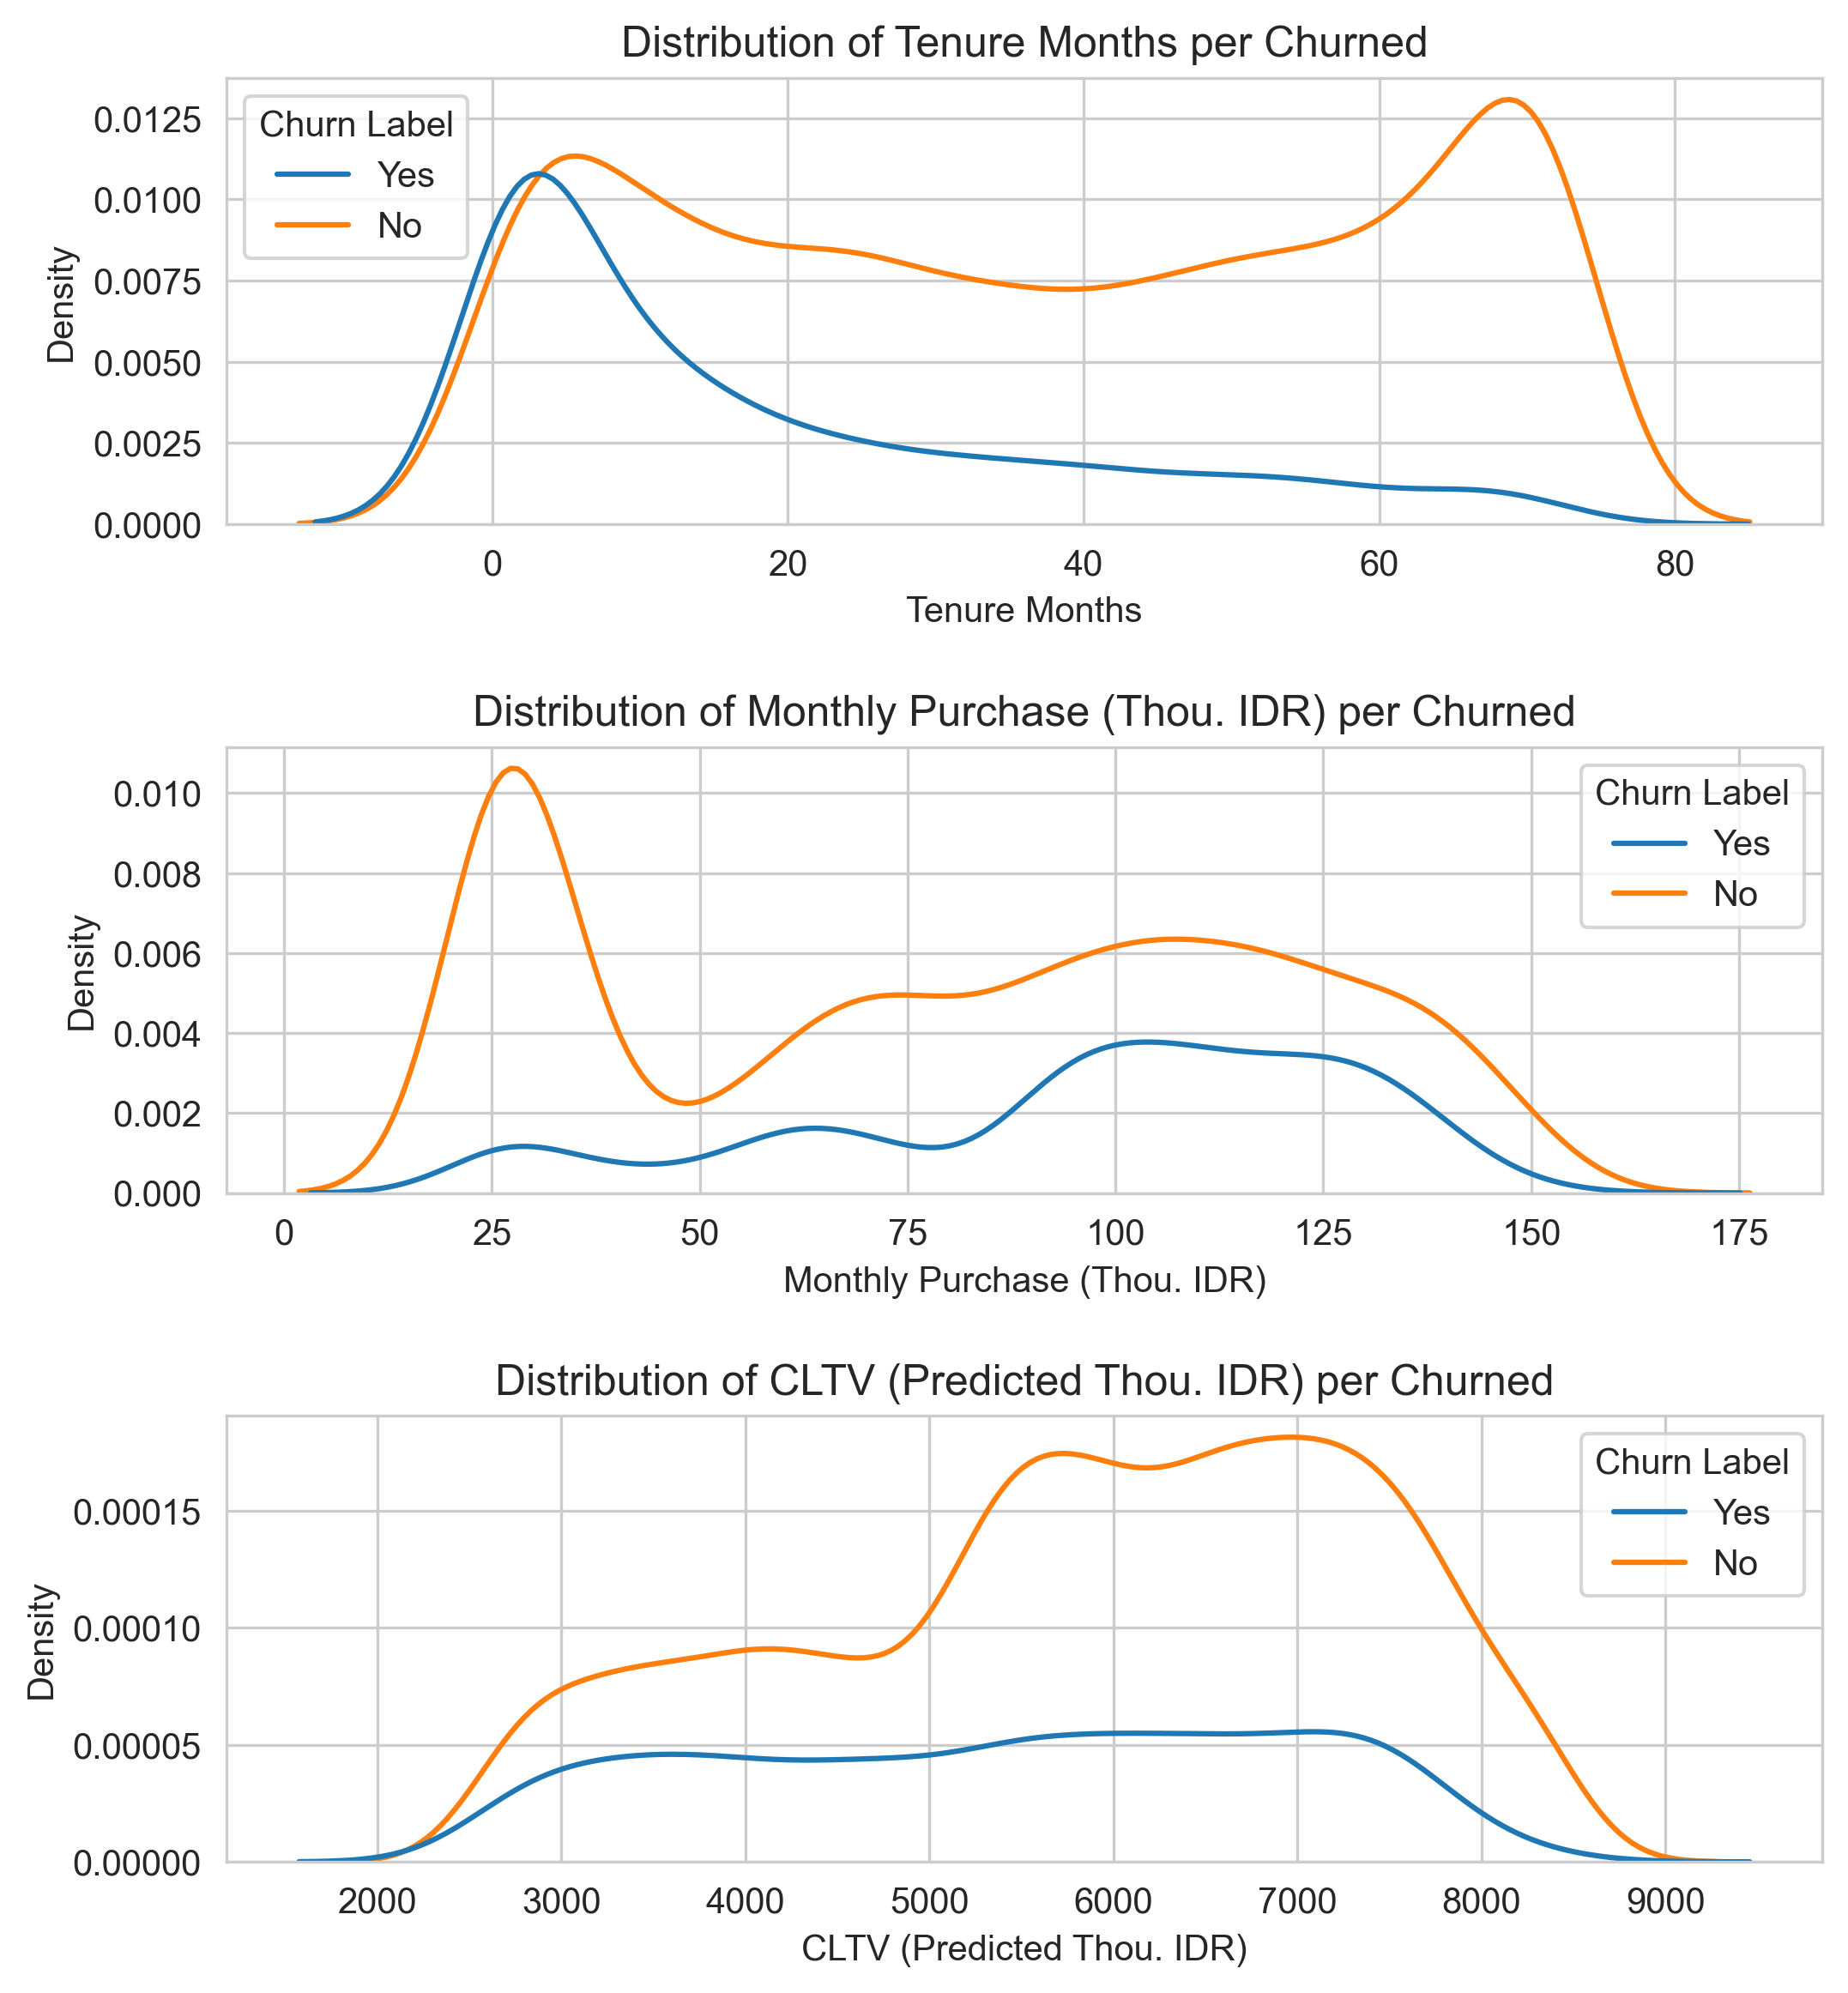

In [18]:
num_col = ['Tenure Months', 'Monthly Purchase (Thou. IDR)',
           'CLTV (Predicted Thou. IDR)']

plt.figure(figsize=(8,9), dpi = 300)
plt.subplots_adjust(hspace=0.5)



for n , col in enumerate(num_col):
    
    ax = plt.subplot(3,1, n + 1)
    
    sns.kdeplot(df, x = col, ax = ax,
               hue = 'Churn Label')
    plt.title(f"Distribution of {col} per Churned")

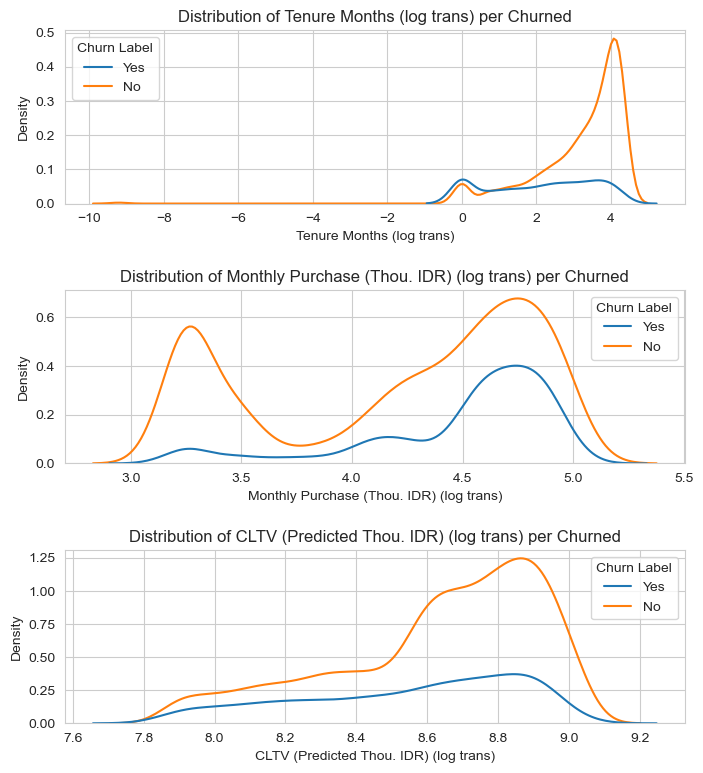

In [19]:
num_col = ['Tenure Months', 'Monthly Purchase (Thou. IDR)',
           'CLTV (Predicted Thou. IDR)']

plt.figure(figsize=(8,9))
plt.subplots_adjust(hspace=0.5)

df_copy = df.copy()


for n , col in enumerate(num_col):
    
    col_log = f"{col} (log trans)"
    df_copy[col_log] = df_copy[col].apply(lambda x: np.log(x + 0.0001))
    ax = plt.subplot(3,1, n + 1)
    
    
    sns.kdeplot(df_copy, x = col_log, ax = ax,
               hue = 'Churn Label')
    plt.title(f"Distribution of {col_log} per Churned")

takeaways:
- rata-rata pelanggan baru <10 tenure month yang ngechurn.
- beberapa yang ngechurn mempunyai monthly purchase 90-120
- rata-rata cltv dari non-churn customer lebih besar daripada churn customer.

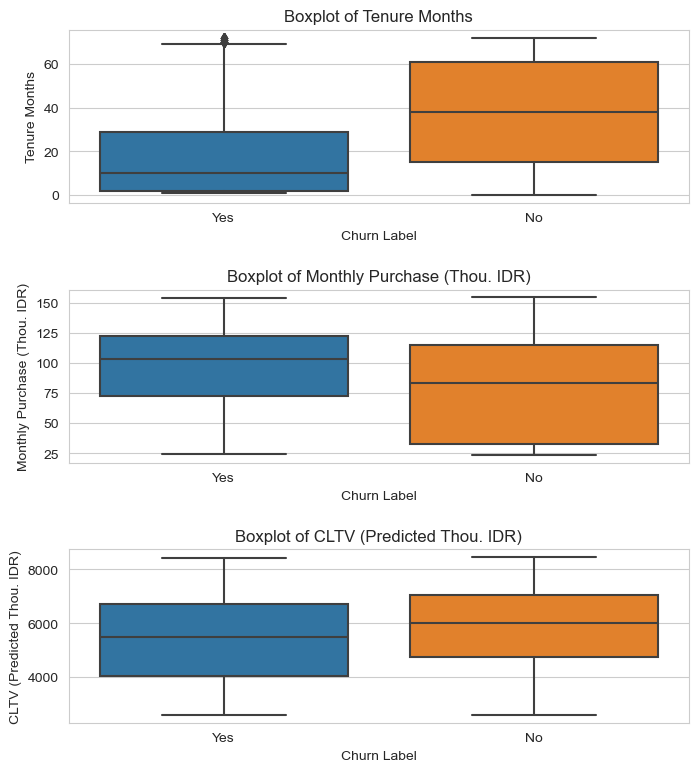

In [20]:
num_col = ['Tenure Months', 'Monthly Purchase (Thou. IDR)',
           'CLTV (Predicted Thou. IDR)']

plt.figure(figsize=(8,9))
plt.subplots_adjust(hspace=0.5)

for n , col in enumerate(num_col):
    
    ax = plt.subplot(3,1, n + 1)
    
    sns.boxplot(df, x = 'Churn Label', y = col)
    plt.title(f"Boxplot of {col}")

In [21]:
df.head()

,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,106.816666,-6.2,4210.7
1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,106.816666,-6.2,3511.3
2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,106.816666,-6.2,6983.6
3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,106.816666,-6.2,6503.9
4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,106.816666,-6.2,6942.0


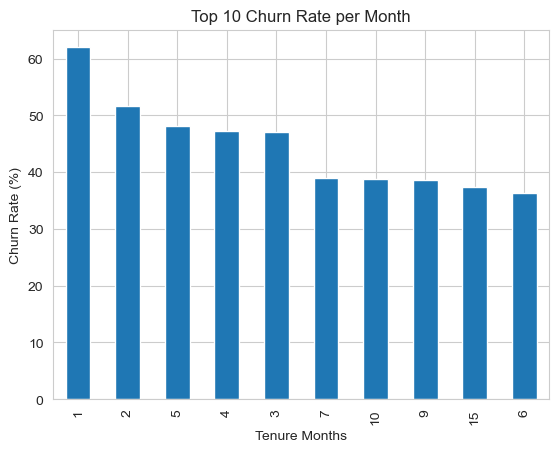

In [22]:
df_total = df.copy()

df_total['Churn Label'] = df_total['Churn Label'].apply(lambda x: 1 if x == "Yes" else 0)

churn_gb = df_total.groupby('Tenure Months')['Churn Label'].sum().reset_index()
churn_gb['Total Case'] = df['Tenure Months'].value_counts().sort_index().reset_index()['Tenure Months']


# Churn Rater per month
(churn_gb['Churn Label']*100/churn_gb['Total Case']).sort_values(ascending = False)[:10].plot(kind = "bar")
plt.title("Top 10 Churn Rate per Month")
plt.ylabel("Churn Rate (%)")
plt.xlabel("Tenure Months")
plt.show()

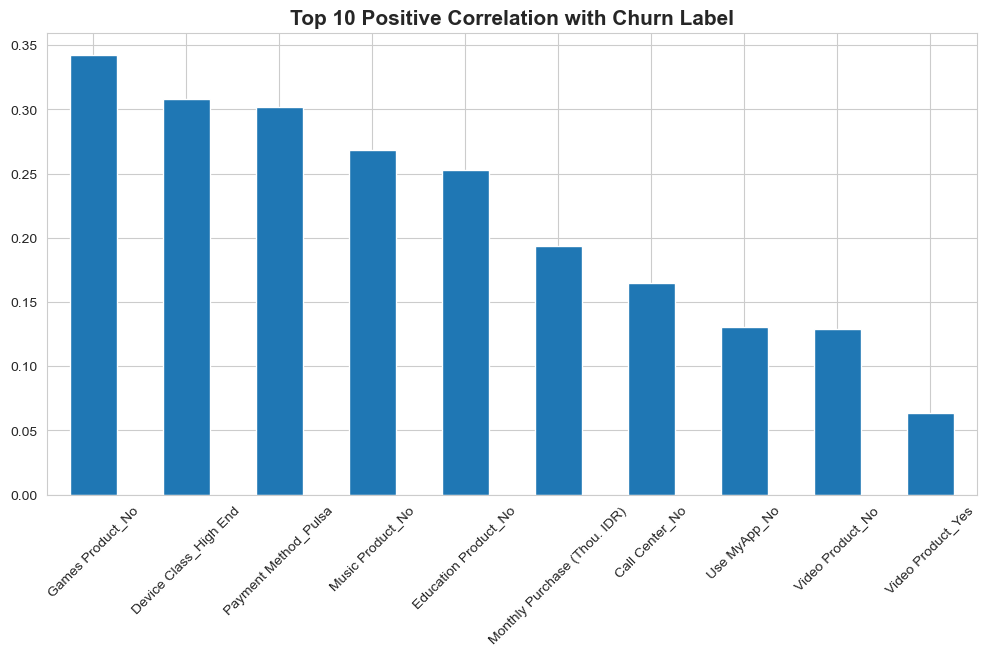

In [23]:
df_corr = df.copy()

df_corr['Churn Label'] = df_corr['Churn Label'].apply(lambda x: 1 if x == 'Yes' else 0)

# One Hot Encoding
for col in df_corr.select_dtypes('object').columns:
    dummy = pd.get_dummies(df_corr[col], prefix = col)
    
    df_corr = df_corr.drop(col, axis = 1)
    
    df_corr = pd.concat([df_corr, dummy], axis = 1)


plt.figure(figsize=(12,6))
df_corr.corr()['Churn Label'].sort_values(ascending = False).drop('Churn Label')[:10].plot(kind = 'bar')
plt.title("Top 10 Positive Correlation with Churn Label", fontsize = 15, fontweight = "bold")
plt.xticks(rotation = 45)
plt.show()

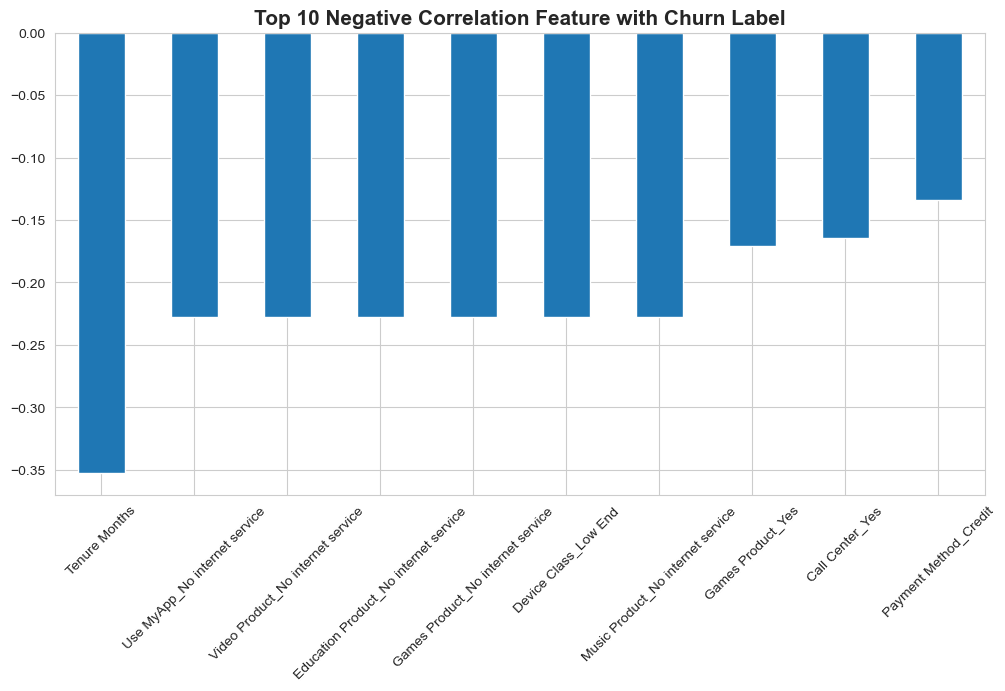

In [24]:
plt.figure(figsize=(12,6))
df_corr.corr()['Churn Label'].sort_values(ascending = True).drop('Churn Label')[:10].plot(kind = 'bar')
plt.title("Top 10 Negative Correlation Feature with Churn Label", fontsize = 15, fontweight = "bold")
plt.xticks(rotation = 45)
plt.show()

**EDA Conclusion :**
- Most of the Churned Customer only uses Video Product.
- Most of the Non-Churned Customer have an even distribution between using Video, Game, Education , and Music Product.
- Most of the Churned Customer, churned when it's only been <5 tenure months.
- Most of the Churned Customer have a high monthly spend that is >100 Thou. IDR, while most of the Non-Churned Customer have a montly spend between 25 and 50 Thousand IDR.
- Most of the Non-Churned Customer have a CLTV between 5500 and 8000 IDR.
- Most of the Churned Customer uses Pulsa as their payment method, while the Non-Churned Customer have an even frequency for other payment method.

# Target Class

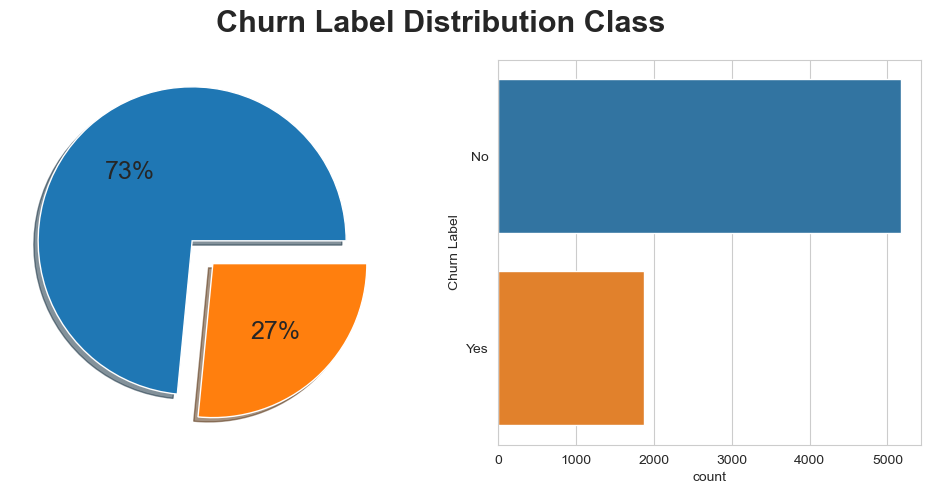

In [25]:
def target_count(df):

    # fig, ax
    fig ,ax = plt.subplots(1,2, figsize=(12,5))



    ax[0].pie(x = df['Churn Label'].value_counts(),
           shadow = True,
           autopct = "%1.f%%",
           textprops = {'size' : 18},
           explode = [.1 for i in range(df['Churn Label'].nunique())])

    sns.countplot(df , y = 'Churn Label',
                 order = df['Churn Label'].value_counts().index)

    plt.suptitle("Churn Label Distribution Class", fontweight ='bold',
             fontsize = 22)
    plt.show()

target_count(df)

There seems to be an unbalanced target class on our dataset. We will fix those unbalanced target class by using resampling method.

# Preprocessing

## Scaler

In [26]:
class FeatureScaler(BaseEstimator, TransformerMixin):
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        
        num_col = ['Tenure Months', 'Monthly Purchase (Thou. IDR)',
                   'CLTV (Predicted Thou. IDR)']
        
        for col in num_col:
            
            # Creating Log Transformation
            X[col] = X[col].apply(lambda x: np.log(x + 0.0001))
        
        return X
        

## Dropper

In [27]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X):
        return self
    
    
    def transform(self, X):
        
        drop_col = ['Longitude', 'Latitude',
                    'Use MyApp', 'Location']
        
        return X.drop(drop_col, axis = 1)

## Encoder

In [28]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        
        cat_col = X.select_dtypes('object').columns
        
        for col in cat_col:
            
            # Create One-Hot Encoding
            dummy = pd.get_dummies(X[col], prefix = col)
            
            # Dropping Original Column
            X = X.drop(col, axis = 1)
            
            # Concate One-Hot Encoding with Original dataframe
            X = pd.concat([X, dummy], axis = 1)
            
        return X

## Creator

In [29]:
class FeatureCreator(BaseEstimator, TransformerMixin):
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        
        # Changing Churn Label Encoding
        X['Churn Label'] = X['Churn Label'].apply(lambda x: 1 if  x == 'Yes' else 0)
        
        cat_col = ['Games Product', 'Music Product', 'Education Product',
                  'Video Product']
        
        for col in cat_col:
            X[col] = X[col].apply(lambda x: 'No' if x == 'No internet service' else x)
        
        return X

## Handle Imbalance Target

In [30]:
def balance_classes(X_t, y_t):
    
    sm = SMOTE(random_state = 42)
    X_t_res, y_t_res = sm.fit_resample(X_t, y_t)
    
    return X_t_res, y_t_res

# Preparing Training and Validation Set

In [31]:
# Make a copy of original df
train_ori = df.copy()

train_set , val_set = train_test_split(df, test_size = 0.2, stratify = df['Churn Label'],
                                       random_state = 42)

# Preparing Data Pipeline

In [32]:
pipeline = Pipeline([("dropper", FeatureDropper()),
                     ("scaler", FeatureScaler()),
                     ('creator', FeatureCreator()),
                     ("encoder", FeatureEncoder())])

# Implement Classifier

In [33]:
# All the models we will try

xgb = XGBClassifier(random_state = 42)
cb = CatBoostClassifier(random_state = 42, verbose = 0)
lgbm = LGBMClassifier(random_state = 42)
rfc = RandomForestClassifier(random_state = 42, n_jobs = -1)
estimator = [('lgbm', lgbm),
             ('xgb', xgb),
             ('cb', cb)]

stack = StackingClassifier(estimators = estimator, final_estimator = LogisticRegression(),
                          cv = 5, n_jobs = -1)


models = [('XGBoost', xgb),
          ('CatBoost', cb),
          ('LGBM', lgbm),
          ('rfc', rfc),
          ('Stacking', stack)]

# Score Metrics
Based on the pie chart of the target class, we know that the target class distribution is imbalanced. So we need to balanced our metrics based on the precision and recall, since recall is how well our model predict the minority class. For that we will use F1-Score, where it is defined as:

$$ F_1 = 2 \cdot \dfrac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}} $$

To calculate F1-Score, we will use scikit-learn built in function $\texttt{f1_score}$.

# Cross Validation
We will evaluate the model using cross-validation using the original dataset that we have. We will apply oversampling to balanced the dataset.

In [35]:
train_ori = pipeline.fit_transform(train_ori)

In [36]:
X , y = train_ori.drop(['Churn Label'], axis = 1), train_ori['Churn Label']

In [37]:
def evaluate_model(clf, X, y, average, label = ''):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    acc = 0
    prec = 0
    rec = 0
    f1 = 0
    f2 = 0
    roc = 0
    
    for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Apply resampling
        X_train, y_train = balance_classes(X_train, y_train)
        
        # Train and predict on the test data
        clf.fit(X_train , y_train)
        y_pred = clf.predict(X_val)
#         print(f"Fold {i+1}")
#         print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
#         print(f"Precision: {precision_score(y_val, y_pred, average=average)}")
#         print(f"Recall: {recall_score(y_val, y_pred, average=average)}")
#         print(f"F1-score: {f1_score(y_val, y_pred, average=average)}")
#         print()
        
        acc += accuracy_score(y_val, y_pred)
        prec += precision_score(y_val, y_pred, average=average)
        rec += recall_score(y_val, y_pred, average=average)
        f1 += f1_score(y_val, y_pred, average=average)
        f2 += fbeta_score(y_val, y_pred, average = average, beta = 2)
        roc += roc_auc_score(y_val, y_pred, average = average)
    
    print(f"{label} Validation Score :")
    print("Averages :")
    print(f"Accuracy: {acc / 5}")
    print(f"Precision: {prec / 5}")
    print(f"Recall: {rec / 5}")
    print(f"F1-score: {f1 / 5}")
    print(f"F2-score: {f2 / 5}")
    print(f"ROC-AUC Score : {roc / 5}")
    print()
    
    return acc/5, prec / 5, rec / 5, f1 / 5, f2 / 5, roc / 5

In [38]:
for (label, clf) in models:
    acc, prec, rec, f1, f2, roc = evaluate_model(clf, X.values, y.values, 'macro',label = label)

XGBoost Validation Score :
Averages :
Accuracy: 0.7597597022388543
Precision: 0.7004301050474295
Recall: 0.7213121514536093
F1-score: 0.7082357093428946
F2-score: 0.7153797726393676
ROC-AUC Score : 0.7213121514536093

CatBoost Validation Score :
Averages :
Accuracy: 0.771687891154268
Precision: 0.716811610598459
Recall: 0.7441297112936771
F1-score: 0.7262030141200585
F2-score: 0.7357928849846995
ROC-AUC Score : 0.7441297112936769

LGBM Validation Score :
Averages :
Accuracy: 0.7604713408929608
Precision: 0.7064744399823002
Recall: 0.7368359221693753
F1-score: 0.7159415684302656
F2-score: 0.7268940678133221
ROC-AUC Score : 0.7368359221693753

rfc Validation Score :
Averages :
Accuracy: 0.7596200762952449
Precision: 0.6962658547406714
Recall: 0.707722052780382
F1-score: 0.7010324458357735
F2-score: 0.7047969024674444
ROC-AUC Score : 0.707722052780382

Stacking Validation Score :
Averages :
Accuracy: 0.7701252903413124
Precision: 0.7141515840122897
Recall: 0.7393037087644594
F1-score: 0.7

Using cross-validation we can see that our CatBoost model achieved the highest F1-Score, that is **0.73** and the highest ROC-AUC score **0.74**. Thus, we will build our model using CatBoost.

# Prediction

In [39]:
train_set_ori = pipeline.fit_transform(train_set)
val_set_ori = pipeline.fit_transform(val_set)

In [40]:
X_train, y_train = train_set_ori.drop('Churn Label', axis = 1), train_set_ori['Churn Label']
X_val , y_val = val_set_ori.drop('Churn Label', axis = 1), val_set_ori['Churn Label']


# Applying Resampling
X_train, y_train = balance_classes(X_train, y_train)

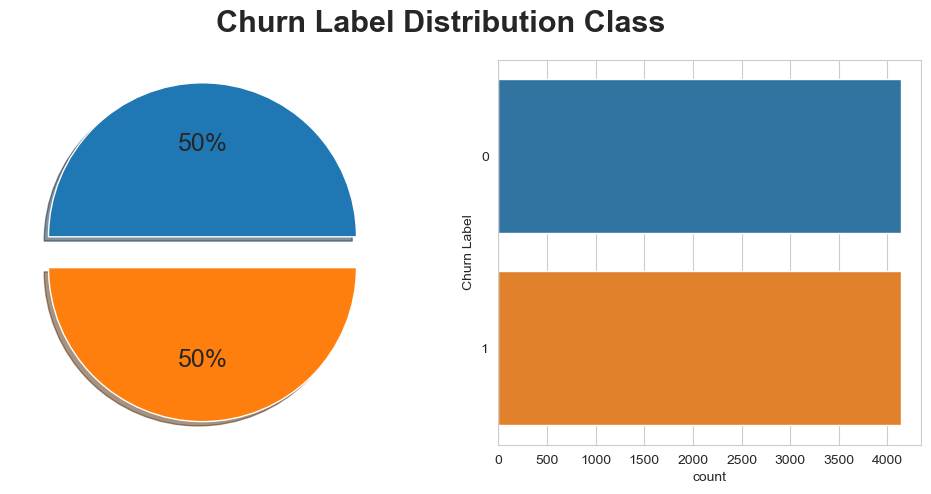

In [41]:
target_count(pd.concat([X_train, y_train], axis = 1))

In [42]:
# We are going to use CatBoost model
cb.fit(X_train , y_train)
y_pred_train = cb.predict(X_train)

print("CatBoost Training Score:")
print(classification_report(y_train, y_pred_train))

CatBoost Training Score:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      4139
           1       0.85      0.91      0.88      4139

    accuracy                           0.88      8278
   macro avg       0.88      0.88      0.88      8278
weighted avg       0.88      0.88      0.88      8278



In [43]:
y_pred_val = clf.predict(X_val)

print("CatBoost Validation Score:")
print(classification_report(y_val, y_pred_val))

CatBoost Validation Score:
              precision    recall  f1-score   support

           0       0.92      0.85      0.89      1035
           1       0.66      0.79      0.72       374

    accuracy                           0.84      1409
   macro avg       0.79      0.82      0.80      1409
weighted avg       0.85      0.84      0.84      1409



Based on these metrics, the model achieved an overall accuracy of **0.84**, meaning it 84% correctly classifies the sample on the dataset. On the other hand, if we look at the precision, recall, and f1-score metrics, our model achieved **0.66, 0.79, 0.72** when classifying target class 1. This was expected since our original data has an imbalance issue.

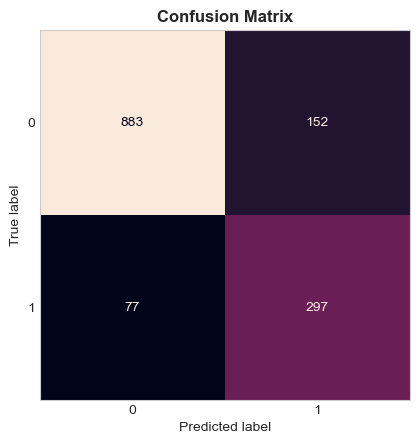

In [44]:

cm = confusion_matrix(y_val, y_pred_val)


disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap = 'rocket', colorbar = False)


plt.title('Confusion Matrix', fontweight = 'bold', fontsize = 12)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)

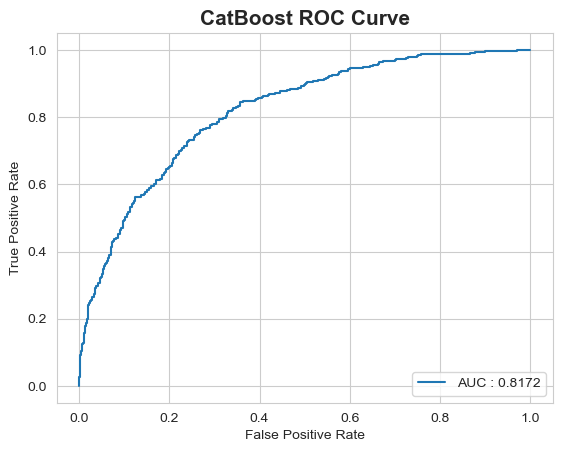

In [45]:
y_pred_proba = cb.predict_proba(X_val)[::,1]
fpr, tpr, _ = roc_curve(y_val,  y_pred_proba)
auc = roc_auc_score(y_val, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label=f"AUC : {auc:.4f}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)

plt.title("CatBoost ROC Curve", fontweight = 'bold', fontsize = 15)
plt.show()

# Hyperparamer Tuning with Optuna

In [46]:
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
def cross_val_score(clf, X, y, cv = skf):
    
    f1 = []
    for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Apply resampling
        X_train, y_train = balance_classes(X_train, y_train)
        
        # Train and predict on the test data
        clf.fit(X_train , y_train)
        y_pred = clf.predict(X_val)
        
        score = f1_score(y_val , y_pred, average = 'macro')
        f1.append(score)
    
    return f1
    

In [47]:
import optuna


def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    
    cb = CatBoostClassifier(random_state = 42, **params, verbose = 0)    
    score = cross_val_score(cb, X.values, y.values, cv = skf)
    
    return np.mean(score)

In [48]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)

# print('Best hyperparameters:', study.best_params)
# print('Best F1-Score:', study.best_value)

Based on trial and error, using hyperparameter tuning will cause our model to underfit, thus in this case we will not be using it.

# Analyzing Feature Importance

In [49]:
def plot_feature_importance(importance, names, model_type):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    # Create a DataFrame using a dictionary
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    
    # Sort the DataFrame in descending order of feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    # Select the top ten most significant features
    fi_df = fi_df.head(10)
    
    # Define plot style
    sns.set(style="whitegrid")

    # Plot feature importance
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=fi_df.feature_importance, y=fi_df.feature_names, palette="rocket")
    plt.title(f"{model_type} Feature Importance", fontweight = 'bold', fontsize = 15)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

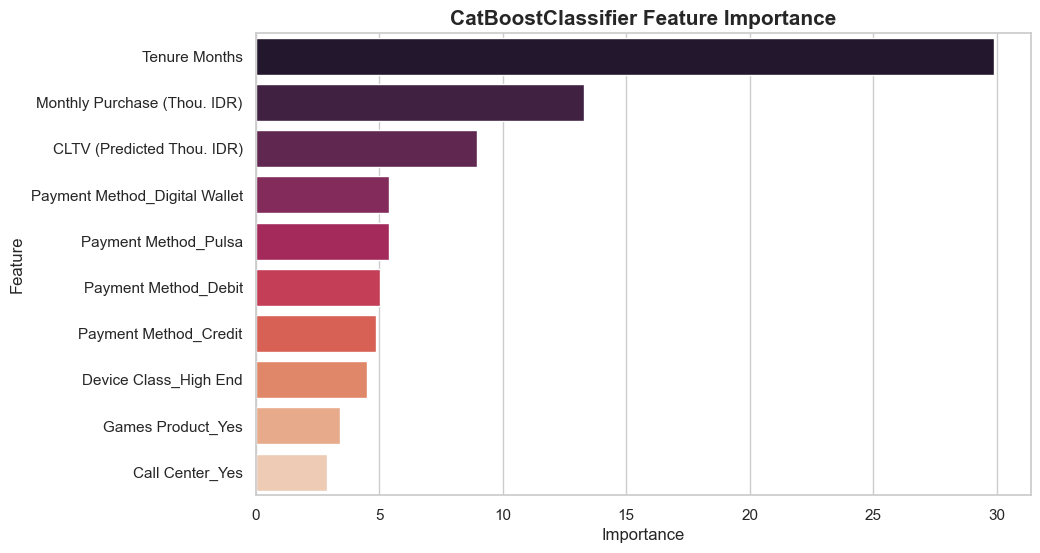

In [50]:
plot_feature_importance(cb.feature_importances_, X_train.columns, cb.__class__.__name__)

Feature [Tenure Months] seems to be the highest importance for our CatBoost model. We can use this feature importance to tune our model by doing feature engineering.

# Saving Model

In [51]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(cb, open(filename, 'wb'))

# Solution
Based on our EDA Conclusion, we can see a couple of problem:
1. Most of the churned customer have a high monthly spend.
2. Most of the churned customer, churned after just <5 Tenure months.
3. Most of the churned customer only uses the Video Product.

So our team propose the solution:
1. We think that, the customer are given a very expensive product, thus the high monthly spend they have. What the company can do is give the newer customer a not so expensive product, but also have a worth it product.
2. We think that the customer churned only after <5 Tenure Months, is due to the expensive product they were given when they try the product, and maybe they dont find it worth it for that kind of price. So again, we should give the newer customer a cheaper product first.
3. We think that, the highly monthly spend that the customer spend only get them a video product. So what we can do, for its expensive price, we can create a bundle or promo for other product.


Furthermore, the machine learning model that our team build can predict customer that will churn. So, for customer that will churn, we can provide them with an interesting promo so that they won't churn.